# A comparison of 10K corhort thrombolysis decisions across single and multiple XG Boost models

Here we train XG Boost models either by training independent models for each hospital, or by one-coding hospitals and training a single model.

The use of thrombolysis in an independent 10K corhort may then be predicted at each hospital by either selecting the individual hospital model for that hospital, or by changing the one-hot encoding to mimic all those 10K patients attending each hospital.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Load data

In [2]:
data_loc = '../../data/sam_1/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

### XG Boost model fitted to each hospital

In [3]:
hospitals = set(train['StrokeTeam'])
counter = 0
models = dict()
observed = []
predicted = []

for hospital in hospitals:
    counter += 1
    print(f'\r{counter}', end='') 
    
    # Get hospital data
    mask = train['StrokeTeam'] == hospital
    X_train_hosp = train[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_train = train[mask]['S2Thrombolysis']
    
    mask = test['StrokeTeam'] == hospital
    X_test_hosp = test[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_test = test[mask]['S2Thrombolysis']
    
    # Define model
    model = XGBClassifier(verbosity = 0)

    # Fit model
    model.fit(X_train_hosp, y_train)
    
    # Save to dictionary
    models[hospital] = model
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_hosp)[:,1]
    y_pred = y_probs > 0.5
    
    # Store results
    observed.extend(y_test.values)
    predicted.extend(y_pred * 1)
    
 # Show accuracy
accuracy = np.mean(np.array(observed) == np.array(predicted))
print (f'\nAccuracy: {accuracy:0.2f}')

132
Accuracy: 0.83


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [4]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []
multi_predictions = []

# Get X and y
X_train = train.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
X_test = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

for hospital in hospitals:
    
    # Get hospital model
    model = models[hospital]
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    multi_predictions.append(y_pred * 1)
    
xgb_multi = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

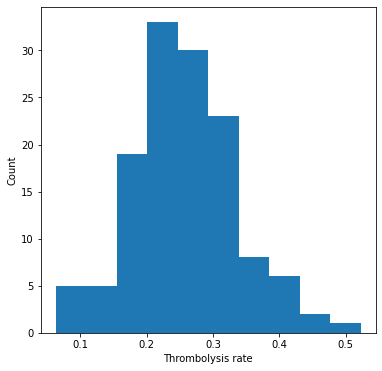

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [6]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.257
StDev: 0.080


## Single XG Boost Model

### Train model

In [ ]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity = 0)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

### Pass 10k cohort through all hospital models and get thrombolysis rate

In [ ]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []
single_predictions = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    single_predictions.append(y_pred * 1)
    thrombolysis_rate.append(y_pred.mean())
    
xgb_single = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [ ]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

## Show comparisions between models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics  

slr = LinearRegression()

def compare(x, y, x_label, y_label):
    
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    
    print(f'R squared {r_square:0.3f}')
    
    plt.scatter (x, y, c = 'blue')
    plt.plot (x, slr.predict(x), color = 'red')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(0,0.5)
    plt.ylim(0,0.5)
    
    plt.show()  
    

In [ ]:
compare(xgb_single, xgb_multi, 'XG Boost single model', 'XG Boost multiple models')

## Test simillarity between all individual predictions

In [ ]:
same_predictions = np.array(single_predictions) == np.array(multi_predictions)
result = same_predictions.mean()
print (f'Proportion predictions the same: {result:0.3f}')